# Multiple Rectangles Detection

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Data Generation

In [2]:
num_imgs = 50000

img_size = 8
min_rect_size = 1
max_rect_size = 4
num_objects = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
        x = np.random.randint(0, img_size - width)
        y = np.random.randint(0, img_size - height)
        imgs[i_img, x:x+width, y:y+height] = 1.
        bboxes[i_img, i_object] = [x, y, width, height]
        
'''        
    # Prevent overlap between rectangles.
    # Makes results (i.e. mean IOU) slightly worse; probably because the shapes are smaller 
    # (i.e. they are harder to recognize and capture within a bbox) 
    # and further apart (i.e. the algorithm can't set all bboxes to the same location to get a good IOU).    
    i_object = 0
    while i_object < num_objects:
        width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
        x = np.random.randint(0, img_size - width)
        y = np.random.randint(0, img_size - height)
        overlap = False        
        print('Creating object', i_object, '- checking', len(bboxes[i_img, :i_object]), 'bboxes for overlap',)
        for bbox in bboxes[i_img, :i_object]:  # TODO: Check if this includes all bboxes.
            overlap = bool(IOU(bbox, [x-1, y-1, width+2, height+2]))  # at least one free field between objects
            if overlap: 
                print('--> Found overlap')
                break
            if not overlap:
                imgs[i_img, x:x+width, y:y+height] = 1.
                bboxes[i_img, i_object] = [x, y, width, height]
                i_object += 1
                print('--> Found no overlap')
'''
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 3, 4))

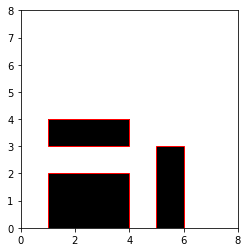

In [20]:
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

## Preprocessing

In [21]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), -6.606271085729532e-17, 1.0000000000000002)

In [22]:
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape

(50000, 12)

## Train Test Split

In [23]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## CNN Model

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

## IoU Calculating Function

In [25]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating function

In [26]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [27]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 

num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, epochs=1, validation_data=(test_X, test_y), verbose=1)
    pred_y = model.predict(train_X)

    for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        pred_bboxes = pred_bboxes.reshape(num_objects, -1)
        exp_bboxes = exp_bboxes.reshape(num_objects, -1)

        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = distance(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with minimum mse and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 10000000#-1  # set mse of assigned bboxes to a large number, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        # Write flipped bboxes to training data.
        flipped_train_y[sample] = exp_bboxes[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  
        # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
            
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))

Epoch 0
1250/1250 [==============================] - 2s 1ms/step - loss: 0.6965 - val_loss: 0.3949
Flipped 66.40916666666666 % of all elements
Mean IOU: 0.006727140984834437
Mean dist: 0.7599117815797228
Mean mse: 0.3429969085765352
Epoch 1
1250/1250 [==============================] - 1s 786us/step - loss: 0.5366 - val_loss: 0.3124
Flipped 12.055833333333336 % of all elements
Mean IOU: 0.010079655720177234
Mean dist: 0.6594768881627949
Mean mse: 0.26908578433745434
Epoch 2
1250/1250 [==============================] - 1s 846us/step - loss: 0.4670 - val_loss: 0.2577
Flipped 12.200833333333334 % of all elements
Mean IOU: 0.013743295553946936
Mean dist: 0.5870252974414205
Mean mse: 0.2204727725308463
Epoch 3
1250/1250 [==============================] - 1s 900us/step - loss: 0.4190 - val_loss: 0.2211
Flipped 11.176666666666668 % of all elements
Mean IOU: 0.017439621634678666
Mean dist: 0.5352713913861437
Mean mse: 0.18819178160432992
Epoch 4
1250/1250 [==============================] - 1s 8

1250/1250 [==============================] - 1s 801us/step - loss: 0.1232 - val_loss: 0.0601
Flipped 1.7383333333333333 % of all elements
Mean IOU: 0.08197520508054769
Mean dist: 0.27643395661341696
Mean mse: 0.045871056101933816
Epoch 36
1250/1250 [==============================] - 1s 815us/step - loss: 0.1207 - val_loss: 0.0591
Flipped 1.6841666666666668 % of all elements
Mean IOU: 0.08319874194073636
Mean dist: 0.27445333768821895
Mean mse: 0.045004802301953736
Epoch 37
1250/1250 [==============================] - 1s 798us/step - loss: 0.1172 - val_loss: 0.0581
Flipped 1.7541666666666667 % of all elements
Mean IOU: 0.08444861063985061
Mean dist: 0.27262485337644987
Mean mse: 0.04417532859375469
Epoch 38
1250/1250 [==============================] - 1s 790us/step - loss: 0.1142 - val_loss: 0.0571
Flipped 1.77 % of all elements
Mean IOU: 0.08586785244881687
Mean dist: 0.2708133848516937
Mean mse: 0.043376614664163794
Epoch 39
1250/1250 [==============================] - 1s 797us/step -

## Flipping Track

Text(0, 0.5, 'Training sample')

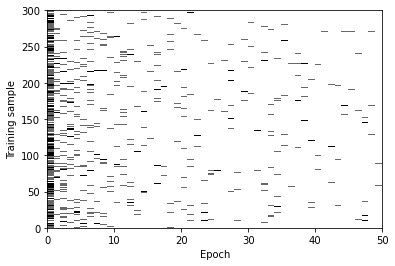

In [28]:
# Show flippings for a few training samples.
plt.pcolor(flipped[:300], cmap='Greys', vmax=1.)
plt.xlabel('Epoch')
plt.ylabel('Training sample')

## Metrics Track

(0.0, 1.0)

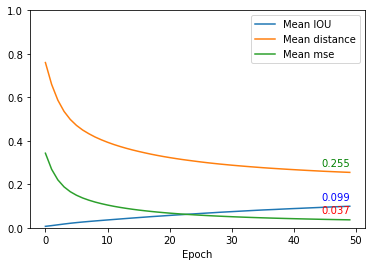

In [29]:
# Plot metrics on the training data. 
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label='Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 1)

# plt.savefig('plots/bw-three-rectangles-50k.png', dpi=300)

## Denormalize Data

In [30]:
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 3, 4)

## Visualize Results

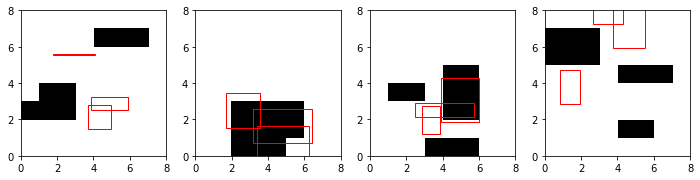

In [31]:
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')